In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity


In [6]:
data = pd.read_csv(
    "data-3.csv",
    engine="python",
    encoding="latin1",
    on_bad_lines="skip"
)


x = data["no2"].dropna().values.astype(np.float32)
x = x.reshape(-1, 1)


In [2]:
r = 102317026
a = 0.5 * (r % 7)
b = 0.3 * ((r % 5) + 1)

print(a, b)

0.0 0.6


In [9]:
z = x + a * np.sin(b * x)
scaler = StandardScaler()
z = scaler.fit_transform(z)

z = torch.tensor(z, dtype=torch.float32)


In [10]:
class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, n):
        return self.net(n)


In [11]:
class discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
g = generator().to(device)
d = discriminator().to(device)

loss_fn = nn.BCELoss()

opt_g = optim.Adam(g.parameters(), lr=0.001)
opt_d = optim.Adam(d.parameters(), lr=0.001)


In [13]:
epochs = 3000
batch = 128

real_lbl = torch.ones(batch, 1).to(device)
fake_lbl = torch.zeros(batch, 1).to(device)

z = z.to(device)

loss_g_list = []
loss_d_list = []

for i in range(epochs):

    idx = torch.randint(0, z.shape[0], (batch,))
    real = z[idx]

    noise = torch.randn(batch, 1).to(device)
    fake = g(noise)
    d_real = d(real)
    d_fake = d(fake.detach())

    loss_d = loss_fn(d_real, real_lbl) + loss_fn(d_fake, fake_lbl)

    opt_d.zero_grad()
    loss_d.backward()
    opt_d.step()
    noise = torch.randn(batch, 1).to(device)
    fake = g(noise)
    d_fake = d(fake)

    loss_g = loss_fn(d_fake, real_lbl)

    opt_g.zero_grad()
    loss_g.backward()
    opt_g.step()

    loss_d_list.append(loss_d.item())
    loss_g_list.append(loss_g.item())

    if i % 500 == 0:
        print(i, loss_d.item(), loss_g.item())


0 1.3881889581680298 0.744502067565918
500 1.4849038124084473 0.6800971031188965
1000 1.3905673027038574 0.7106351256370544
1500 1.3863351345062256 0.6908517479896545
2000 1.3725579977035522 0.6811448335647583
2500 1.4347859621047974 0.6898999214172363


In [19]:
g.eval()
n = 10000
noise = torch.randn(n, 1).to(device)
with torch.no_grad():
    z_fake = g(noise).cpu().numpy()

z_fake = scaler.inverse_transform(z_fake)
z_real = scaler.inverse_transform(z.cpu().numpy())


In [20]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.2)
kde.fit(z_fake)

z_grid = np.linspace(z_real.min(), z_real.max(), 1000).reshape(-1, 1)
pdf = np.exp(kde.score_samples(z_grid))


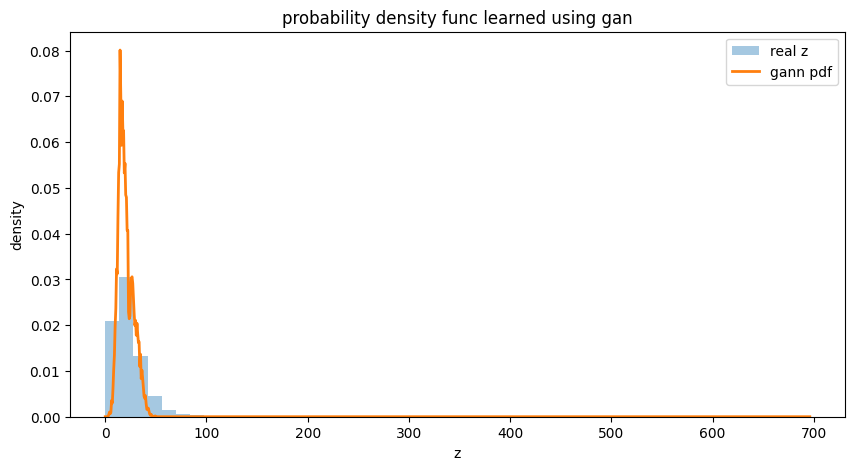

In [21]:
plt.figure(figsize=(10,5))
plt.hist(z_real, bins=50, density=True, alpha=0.4, label="real z")
plt.plot(z_grid, pdf, label="gann pdf", linewidth=2)
plt.xlabel("z")
plt.ylabel("density")
plt.legend()
plt.title("probability density func learned using gan")
plt.show()
